This notebook contains my first try at inmplementing "SonarNet", a CNN architecture based upon Alex net that attempts to detect targets in Sonar Range-doppler maps. A quick description:

Sonars work by emitting a pulse into the water and processing the return. There are lots of types of sonars: the one here is modelled after what might be on a torpedo. The torpedo moves between 10 and 25 m/s and the sonar is on the nose. Unlike fishfinders, this sonar has a fairly narrow transmit beam approximately 36 degrees wide and even narrow receive beams, approximately 9 degrees wide. There is one transmit beam but 25 receive beams arranged in a 5x5 grid with 9 degree separation. 

The target is either a submarine or an echo repeater. The submarined is modelled as a cylindrical tube 10 meters across with hemi-sphereical encaps on either end plus a propellor. The echo consists of a large "specular" reflection, a set of reflections along each side, and some scattering from the propellor. The echo repeater simply repeats the incomput pulse 10 times.

The Sonar is Doppler sensitive, since in general submarines are moving. The receive signal for each receive beam is converted into a "Range Doppler Map", which is a spectrogram: a 256 point sliding window is put over the samples and FFTs run on those "frames". The level is turned into a image. In this work each sonar cycle, about 2 seconds long, generates 93 frames of 256 frequency bins.

In addition to ambient noise, modelled as temporally and spatially white here, the primary interfering signal is the reverberation: scattering off of bubbles and other small things in the water and off of the surface and bottom. 

The first thing is to include the things we need here

In [49]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.utils.model_zoo as model_zoo
from torch.utils.data import Dataset, DataLoader

Now, in order to manage the data, we define our own data set loader. The data her was generated using a MATLAB simulation I developed for other work, modified for this exploration. It puts it's data into a directory with four file types. The raw beam spectrogram outputs are stored as 1 byte colors similar to a color channel in a jpeg as a 25x93x256 matrix. The "LabelMap" is a the lable, a 93x256 point map of 1's and 0s, indicating the presence or absence of a target in that frame/bin. The "FeatureMap" is a vector of 40 floating point values: 8 sets of 5 values consisting of the torpedo relative x,y,z,doppler, and validity flag. Think of this as the bounding box parameters for a differently trained net. These three files are named "ImageMap-<ID>.dat", "LabelMap-<ID>.dat", and "FeatureMap-<ID>.dat" where <ID> is a unique 8 digit number generated from the time that the data was generated by the model. I am not currently using the FeatureMaps


Lastly, there is a "Directory", which is simply a list of all the IDs. 

There are in total 50,000 maps: 30,000 for training, 10,000 for validation, and 10,000 for test. Each instance has a random selection of: target presence, location, attitude, and velocity, decoy presence, location, and false-doppler, water depth, torpedo depth and velocity, bottom type, wind speed, and volume scattering strength. There is a target present in 50% of the samples and a decoy present in 50% of the samples. Thus 25% of the samples have neither and 25% have both, with the remaining 50% having one or the other.

In [50]:
class SonarDataset(Dataset):
    """ Sonar Dataset: for reading my generated Sonar data """

    def __init__(self, root_dir,partition = 'train'):
        """
        Args:
             root_dir (string): path to the data directory
        """
        self.root_dir = root_dir
        self.partitions = {'train': range(0,15000),
                           'validate': range(15000,20000),
                           'test': range(20000,25000)}
        self.directory = np.loadtxt(root_dir + '/Directory.txt').astype(int)
        self.indices = self.partitions[partition]; 

    def __len__(self):
        return len(self.indices)

    def __getitem__(self,idx):
        index = self.indices[idx]
        X = np.fromfile(self.root_dir + '/Image-' +
                        str(self.directory[index]) + '.csv',
                       dtype='uint8').astype(float)
        X.shape = (25, 128, 256)
        X = torch.from_numpy(X).float()
        y = np.fromfile(self.root_dir + '/LabelMap-' +
                        str(self.directory[index]) + '.csv',
                       dtype='uint8').astype(float)
        y.shape = (128,256)
        
        # Now project onto range and frequency axes
        range = y.max(1)
        freq = y.max(0)
        range.shape = (128,)
        freq.shape = (256,)
        y = np.concatenate((range,freq))
        y = torch.from_numpy(y).float()
        
        return X, y


Now, let's test that by intantiating it and getting a data set

X:  torch.Size([25, 128, 256]) Y:  torch.Size([384])


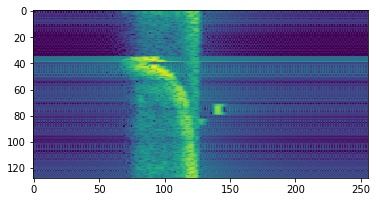

In [51]:
dataDir = '/Users/Matt/Documents/URI/Classes/CSC 592 Deep Learning/Project/GeneratedData'
trainingSet = SonarDataset(dataDir,partition = 'train')
X, y = trainingSet.__getitem__(5)

print("X: ",X.shape,"Y: ",y.shape)
plt.figure
plt.imshow(X[13,:,:])


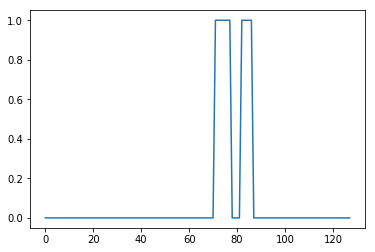

In [52]:
plt.figure
plt.plot(y[:128].numpy())

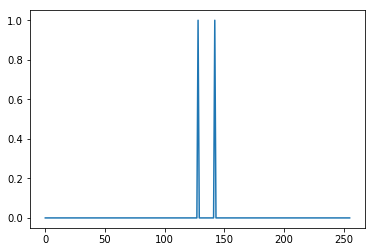

In [53]:
plt.figure
plt.plot(y[128:].numpy())

Having done that, now we define the SonarNet. This is taken from a git repo template I found and modified for this work. Right now I am 

In [62]:
class SonarNet(nn.Module):

    def __init__(self):
        
        super(SonarNet, self).__init__()
        # This is the "front end", which learns the convolutions I hope
        self.frontEnd = nn.Sequential(
            # This I chose because I feel like the echoes are contained in 
            # a fairly tight space along the frequency axis, but they 
            # can be right at the edge so I do a full padding here. 
            # The output will be 25x128x256
            nn.Conv2d(25,25, kernel_size=(3,3),padding = (1,1),groups=25),
            nn.ReLU(inplace=True),
            nn.Conv2d(25,25, kernel_size=(3,3),padding = (1,1),groups=25),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=1,padding=1),
            
            nn.Conv2d(25,25, kernel_size=(3,3),padding = (1,1)),
            nn.ReLU(inplace=True),
            nn.Conv2d(25,25, kernel_size=(3,3),padding = (1,1)),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=1,padding=1),
            
        )
        
        # So this "rangenet" expands into 1 plane for each range bin we hope
        # The input is the output of the above layer, the output of size 1x1x128
        # 128 we hope
        self.rangeNet = nn.Sequential(
            nn.Conv2d(25,128,kernel_size=11),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=(128,256)),
        )
        
        # And similarly, this "binnet" expands into 1 plane for each frequency
        # bin we hope. The output here is 1x1x128 we hope
        self.frequencyNet = nn.Sequential(
            nn.Conv2d(25,256,kernel_size=11),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=(256,256),)
        )
        
        
        # And now the classifier layer.
        self.classifier = nn.Sequential(
            nn.Dropout(),
            nn.Linear(128+256, 128+256),
            nn.ReLU(inplace=True),
            nn.Dropout(),
            nn.Linear(128+256, 128+256),
            nn.Sigmoid()
        )

    def forward(self, x):
        
        # Run the front end
        front = self.frontEnd(x)
        
        # now run the freqency and range nets
        range = self.rangeNet(front)
        frequency = self.frequencyNet(front)

        # Now to catenate them together
        range = range.view(range.size(0),128)
        frequency = frequency.view(frequency.size(0),256)
        both = torch.cat((range,frequency),1)
        x = self.classifier(both)
        return x

Now, let's see if we can do some training or at least loop through a few things

In [63]:
loader = DataLoader(trainingSet,batch_size = 5)
model = SonarNet().float()
optim = torch.optim.SGD(model.parameters(),lr=1e-2)
index = 0
for epoch in range(1,10):
    print("Do Epoch: ",epoch)
    runningLoss = 0
    for X_batch, y_batch in loader:
        y_pred = model.forward(X_batch)
        loss = torch.nn.functional.mse_loss(y_pred,y_batch)
        runningLoss += loss.item()

        loss.backward()
        optim.step()
        optim.zero_grad()
        
        if (index%5==0):
            print("Index: ", index, " Loss: ",runningLoss/5)
            runningLoss = 0
            
        if (index %20 == 0):
            fileName = 'CheckPoint-' + str(index) +'.pth'
            state = {'epoch': epoch+1,
                     'state_dict':model.state_dict(),
                     'optimizer': optim.state_dict()}
            torch.save(state,fileName)
            print('Saved Checkpoint: ',fileName)
        index +=1

Do Epoch:  1
Index:  0  Loss:  0.05816616415977478
Saved Checkpoint:  CheckPoint-0.pth
Index:  5  Loss:  0.27443037629127504
Index:  10  Loss:  0.25668973922729493
Index:  15  Loss:  0.2519823133945465
Index:  20  Loss:  0.24889458417892457
Saved Checkpoint:  CheckPoint-20.pth
Index:  25  Loss:  0.24514759480953216
Index:  30  Loss:  0.24453818202018737
Index:  35  Loss:  0.242142453789711
Index:  40  Loss:  0.24132058322429656
Saved Checkpoint:  CheckPoint-40.pth
Index:  45  Loss:  0.2404721200466156
Index:  50  Loss:  0.23843404054641723
Index:  55  Loss:  0.23776595890522004
Index:  60  Loss:  0.23695550560951234
Saved Checkpoint:  CheckPoint-60.pth
Index:  65  Loss:  0.23470102548599242
Index:  70  Loss:  0.23483847379684447
Index:  75  Loss:  0.23319734036922454
Index:  80  Loss:  0.23278749287128447
Saved Checkpoint:  CheckPoint-80.pth
Index:  85  Loss:  0.22980621755123137
Index:  90  Loss:  0.22853759229183196
Index:  95  Loss:  0.22855417132377626
Index:  100  Loss:  0.2264271

KeyboardInterrupt: 